In [474]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd


In [475]:
data = pd.read_csv("./data.csv")
print(data.head())

#print(data[data["subject"] == 1]) # Select all data from 1 participant

subj_order = data[data["subject"] == 1]["shape_num"]
subj_rt = data[data["subject"] == 1]["RT_trimmed"]
#subj_rt_idk = data[(data["subject"] == 1) & (data["odd_even"] == "o")]["RT_trimmed"]

print(data["RT_trimmed"])


y_train = subj_rt[:24*20].to_numpy()
y_test = subj_rt[-(24*4):].to_numpy()

X_train = subj_order[:24*20].to_numpy()
X_test = subj_order[-(24*4):].to_numpy()


def gen_data(d):
    data = np.empty((0, 24))
    for index in d:
        # Create an array of zeros with length 24
        result_array = np.zeros(24)
        result_array[d[index] - 1] = 1
        data = np.vstack((data, result_array))
    return data

X_train = gen_data(X_train)
X_test = gen_data(X_test)

print(X_train.shape)
print(y_train.shape)

print(X_train)
#print(y_train.to_numpy())



X_train = np.reshape(X_train, (20, 24, 24))
X_test = np.reshape(X_test, (4, 24, 24))

X_train = np.reshape(X_train, (20*24, 1, 24))
X_test = np.reshape(X_test, (4*24, 1, 24))

y_train = np.reshape(y_train, (20, 24, 1))
y_test = np.reshape(y_test, (4, 24, 1))

y_train = np.reshape(y_train, (20*24, 1, 1))
y_test = np.reshape(y_test, (4*24, 1, 1))

print("woow",y_train.shape)
print(np.squeeze(y_train))


   subject         ave          sd  block  triplet  position  shape_num    RT  \
0        1  463.309028  298.476633      1        1         1          1  1121   
1        1  463.309028  298.476633      1        1         2          2   886   
2        1  463.309028  298.476633      1        1         3          3   837   
3        1  463.309028  298.476633      1        7         1         19   843   
4        1  463.309028  298.476633      1        7         2         20  1264   

    RT_trimmed  log_RT_trimmed  change?  block>12  block>18  block>6  \
0  1060.262293        6.966272        1     False     False    False   
1   886.000000        6.786717        0     False     False    False   
2   837.000000        6.729824        0     False     False    False   
3   843.000000        6.736967        0     False     False    False   
4  1060.262293        6.966272        1     False     False    False   

   1-avg(2,3)  log_1-avg(2,3) odd_even  
0         NaN             NaN        o 

In [476]:
def build_network(learning_rate: float = 0.005):
     model = tf.keras.Sequential()
     model.add(tf.keras.Input(shape=(1,24)))
     model.add(tf.keras.layers.SimpleRNN(40, return_sequences = False, activation = "linear"))
     model.add(tf.keras.layers.Dense(1, activation = "linear"))
     loss = tf.keras.losses.CategoricalCrossentropy()
     model.compile(optimizer = \
        #tf.keras.optimizers.Adam(learning_rate = learning_rate), loss = loss, metrics = ["accuracy"])	
        #tf.keras.optimizers.Adam(learning_rate = learning_rate), loss='mean_squared_error', metrics = ["accuracy"])
      tf.keras.optimizers.Adam(
         learning_rate = learning_rate), 
         loss='mean_squared_error', 
         metrics=[
            tf.keras.metrics.mean_squared_error,
            tf.keras.metrics.mean_absolute_error,
            tf.keras.metrics.mean_absolute_percentage_error]
         )
     return model
     """
    model = tf.keras.Sequential()
    #model.add(tf.keras.Input(shape = (480,24)))
    model.add(tf.keras.layers.SimpleRNN(19))
    model.add(tf.keras.layers.Dense(1, activation = "relu"))
    loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = \
         tf.keras.optimizers.Adam(learning_rate = learning_rate), loss = loss, metrics = ["accuracy"])	
     """	

In [477]:
def train_model():
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    #res = model.fit(X_train, y_train, epochs = 200, validation_data = (X_test, y_test))
    res = model.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test))
    return res

In [478]:
def show_res(res, verbose: bool = False):
    print(res.history.keys())
    if verbose:
        print(res.history)
    fig, axs = plt.subplots(2,2)
    axs[0, 0].set_title("training loss")
    axs[0, 0].plot(res.history["loss"])
    axs[0, 1].set_title("mean_squared_error")
    axs[0, 1].plot(res.history["mean_squared_error"])
    axs[1, 0].set_title("val_mean_absolute_percentage_error")
    axs[1, 0].plot(res.history["val_mean_absolute_percentage_error"])
    axs[1, 1].set_title("val_mean_absolute_error")
    axs[1, 1].plot(res.history["val_mean_absolute_error"])
    plt.show()

model predictions [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
test scores 244.0
(480, 1, 24) (480, 1, 1) (96, 1, 24) (96, 1, 1)
Epoch 1/20
15/15 [==============================] - 1s 23ms/step - loss: 296798.6230 - mean_squared_error: 296798.6230 - mean_absolute_error: 490.0771 - mean_absolute_percentage_error: 99.9243 - val_loss: 74564.4609 - val_mean_squared_error: 74564.4609 - val_mean_absolute_error: 258.8948 - val_mean_absolute_percentage_error: 99.5008
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 308282.9043 - mean_squared_error: 308282.9043 - mean_absolute_error: 494.3489 - mean_absolute_percentage_error: 99.5489 - val_loss: 73473.4922 - val_mean_squared_error: 73473.4922 - val_mean_absolute_error: 256.7756 - val_mean_absolute_percentage_error: 98.6540
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 299837.6523 - mean_squared_error: 299837.6523 - mean_absolute_error: 488.2119 - mean_absolute_percent

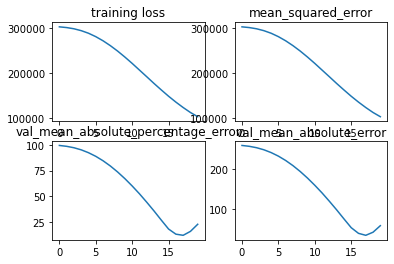

In [479]:
train_size, test_size = 480, 96 # downscale to make data set smaller (and training faster)

print("model predictions", X_test[0,0])
print("test scores", y_test[0,0,0])

model = build_network()
res = train_model()
model.summary()

print("model predictions", model.predict(X_test))
print("test scores", y_test)
show_res(res)

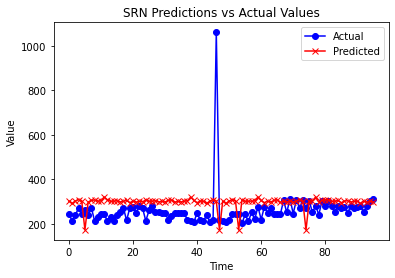

In [480]:
plt.plot(np.squeeze(y_test), label='Actual', color='blue', marker='o')
plt.plot(model.predict(X_test), label='Predicted', color='red', marker='x')
#print(np.squeeze(y_train))

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('SRN Predictions vs Actual Values')

# Add legend
plt.legend()

# Show the plot
plt.show()